In [1]:
import pathlib
import librosa
import numpy as np
import scipy
from tqdm import tqdm
import torch
import warnings
from PIL import Image
import matplotlib.pyplot as plt
import datetime
from loguru import logger
import os
import wandb

import itertools

from utils import compute_frequency_representation
from sensory_preprocessor import SensoryPreprocessor
import json
from brain_modules import FFNet, RecIntegrationModule, FFVisualModuleEncoder, FFVisualModuleDecoder

warnings.filterwarnings(action='ignore')
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    print('Using CPU')

Using GPU: NVIDIA GeForce RTX 4080 SUPER


In [2]:
'''
The minimal info you'd want to include would be a cochleagram of the input (a power spectrum of the chunk would do, but a cochleagram output would be better )
but if you're going to chunk it into 40 ms bins then you should give it the frequency representation (averaged over time)
and the mean ILD and mean ITD for that chunk;
otherwise you're going to have to have to consider the sound at a resolution that gives you ITDs.
Given you have a set of ITD detectors in the brainstem its not a crazy thing to provide the model with.
The choice of clicks at a relatively slow rate makes a lot of sense as at least they are brief enough you don't need to worry about multiple clicks occuring within a chunk.
It might be worth taking a look at some papers from Josh McDermott - he's the person who has done most on auditory perception based  machine learning but there aren't many people considering binaural cues in this domain.
'''
recording_name = 'Movie_021'
path_to_audio = pathlib.Path(f'./data/processed/{recording_name}/audio/audio.mp3')
path_to_video = pathlib.Path(f'./data/processed/{recording_name}/frames')
path_to_aux = pathlib.Path(f'./data/trajectories/3000s_dt_0.02_switch_rect_riab_trajectory.json')
audio, sr = librosa.load(path_to_audio,sr=None, mono=False)
frames = [i for i in path_to_video.glob('*.jpg')]

# vision module parameters
vision_modules_timestamp = '20240605_222435'
visual_loss_fn = torch.nn.BCELoss()
visual_embedding_dim = 200
img_dim = (160, 120)
grayscale = False
c_channels = 1 if grayscale else 3

# sensory preprocessor parameters
tsteps = 10
batch_size = 600
sp = SensoryPreprocessor(audio_path=path_to_audio,
                         video_path=path_to_video,
                         aux_path=path_to_aux,
                         tsteps=tsteps,
                         n_frames=150000,
                         grayscale=grayscale)
sp.ttv_split(seed=seed)

# auditory module parameters
auditory_modules_timestamp = '20240605_213341' # 20240529_164044 - frozen encoder and decoders.
auditory_loss_fn = torch.nn.MSELoss()
freq_dim = 884
auditory_hidden_dim = 400
auditory_embedding_dim = 200

# rec module parameters
int_module_hidden_dim = 400
n_rec_layers = 1
aux_dim = 3
alpha = 1e-5
rec_interval = 3 # frame rate provided to the rec network. 1 = 0.02 seconds

### pre-train visual encoder and decoder

In [3]:
vision_enc = FFVisualModuleEncoder(visual_embedding_dim=visual_embedding_dim, img_dim=img_dim, grayscale=grayscale, device=device)
vision_dec = FFVisualModuleDecoder(input_dim=visual_embedding_dim, threshold_dims=vision_enc.threshold_dims, grayscale=grayscale, device=device)

vision_enc.load_state_dict(torch.load(f'./trained_models/{recording_name}_vision_enc_{visual_embedding_dim}_{vision_modules_timestamp}.pth'))
vision_dec.load_state_dict(torch.load(f'./trained_models/{recording_name}_vision_dec_{visual_embedding_dim}_{vision_modules_timestamp}.pth'))
logger.info(f'Successfully loaded pretrained vision modules timestamp: {vision_modules_timestamp}')

2024-06-13 14:37:41.042 | INFO     | __main__:<module>:6 - Successfully loaded pretrained vision modules timestamp: 20240605_222435


Visual loss of training set image:  0.5307838320732117


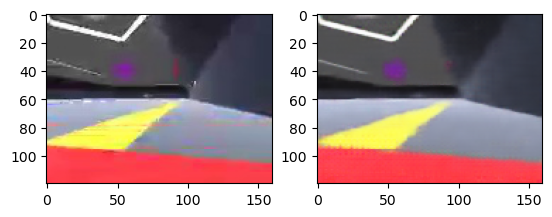

Visual loss of test set image:  0.5351949334144592


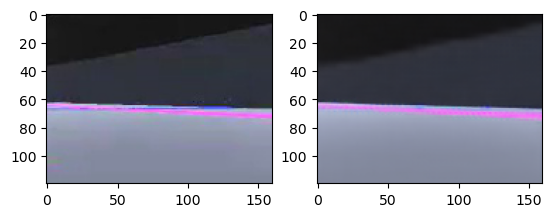

In [4]:
# sample from training set:
img, audio, aux, pos = sp.get_batches(random=True, ttv='tr', get_pos=True)
img = torch.as_tensor(img, dtype=torch.float32).view(-1, c_channels, 160, 120).to(device)
img_recon = vision_dec(vision_enc(img))
with torch.no_grad():
    x = np.random.randint(img.shape[0]) # randomly sample an index from batch
    print('Visual loss of training set image: ', visual_loss_fn(img_recon[x], img[x]).item())
    plt.subplots(1,2)
    plt.subplot(121)
    plt.imshow(np.swapaxes(img[x].cpu().numpy(),0,2))
    plt.subplot(122)
    plt.imshow(np.swapaxes(img_recon[x].cpu().numpy(),0,2))
    plt.show()

# sample from test set:
img, audio, aux, pos = sp.get_batches(random=True, ttv='test', get_pos=True)
img = torch.as_tensor(img, dtype=torch.float32).view(-1, c_channels, 160, 120).to(device)
img_recon = vision_dec(vision_enc(img))
with torch.no_grad():
    x = np.random.randint(img.shape[0])
    print('Visual loss of test set image: ', visual_loss_fn(img_recon[x], img[x]).item())
    plt.subplots(1,2)
    plt.subplot(121)
    plt.imshow(np.swapaxes(img[x].cpu().numpy(),0,2))
    plt.subplot(122)
    plt.imshow(np.swapaxes(img_recon[x].cpu().numpy(),0,2))
    plt.show()

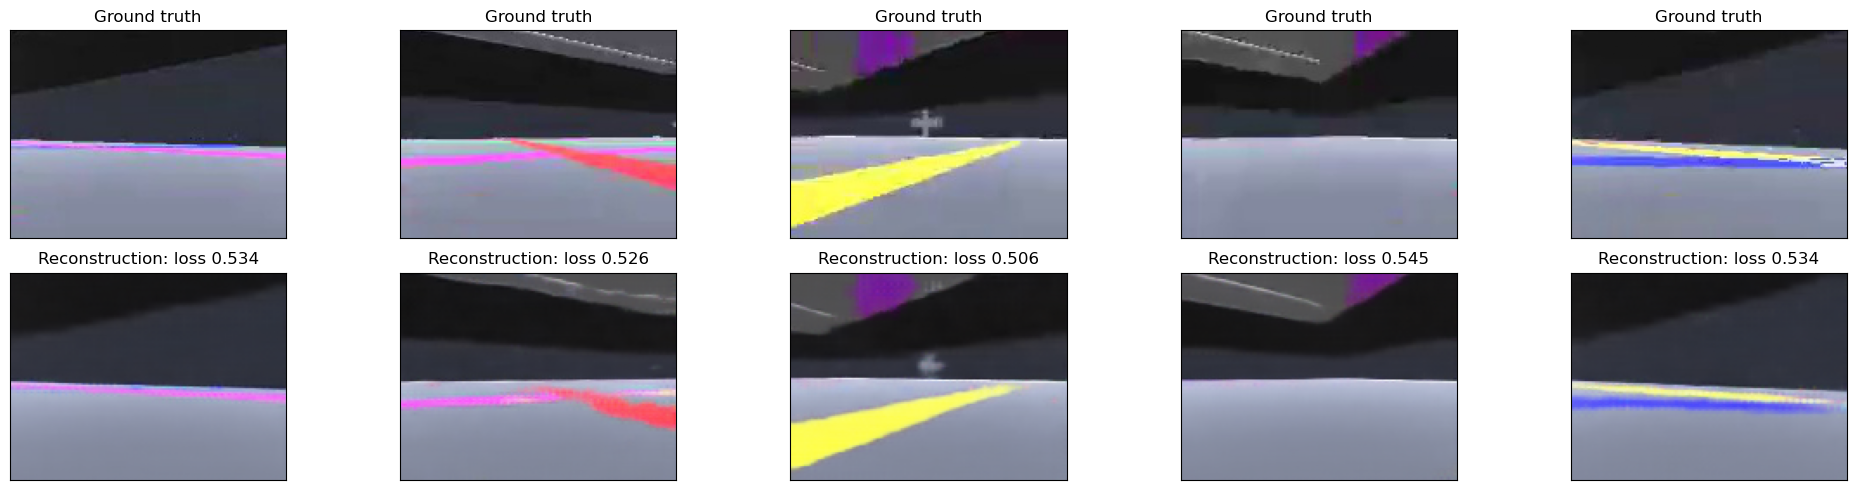

In [5]:
n = 5
plt.subplots(2,n, figsize=(20,5))
img_losses = []
sp.reset_pointers()
for i in range(n):
    # sample from test set:
    
    img, audio, aux, pos = sp.get_batches(random=True, ttv='test', get_pos=True)
    img = torch.as_tensor(img, dtype=torch.float32).view(-1, c_channels, 160, 120).to(device)
    img_recon = vision_dec(vision_enc(img))
    img_losses.append(visual_loss_fn(img_recon, img).item())

    with torch.no_grad():
        x = np.random.randint(img.shape[0])
        # print('Visual loss of test set image: ', visual_loss_fn(img_recon[x], img[x]).item())
        plt.subplot(2,n,i+1)
        plt.imshow(np.swapaxes(img[x].cpu().numpy(),0,2))
        plt.xticks([])
        plt.yticks([])
        plt.title('Ground truth')
        plt.subplot(2,n,i+6)
        plt.imshow(np.swapaxes(img_recon[x].cpu().numpy(),0,2))
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Reconstruction: loss {str(visual_loss_fn(img_recon[x], img[x]).item())[:5]}')

plt.tight_layout()
plt.savefig(f'./report_figs/vision_reconstructions.png', dpi=200, )

plt.show()

### pre-train auditory encoder and decoder

In [6]:
auditory_enc = FFNet(input_dim=freq_dim, hidden_dim=auditory_hidden_dim, output_dim=auditory_embedding_dim, device=device)
auditory_dec = FFNet(input_dim=auditory_embedding_dim, hidden_dim=auditory_hidden_dim, output_dim=freq_dim)

auditory_enc.load_state_dict(torch.load(f'./trained_models/{recording_name}_auditory_enc_{auditory_hidden_dim}_{auditory_embedding_dim}_{auditory_modules_timestamp}.pth'))
auditory_dec.load_state_dict(torch.load(f'./trained_models/{recording_name}_auditory_dec_{auditory_hidden_dim}_{auditory_embedding_dim}_{auditory_modules_timestamp}.pth'))
logger.info(f'Successfully loaded auditory modules at timestamp: {auditory_modules_timestamp}')

2024-06-13 14:37:45.844 | INFO     | __main__:<module>:6 - Successfully loaded auditory modules at timestamp: 20240605_213341


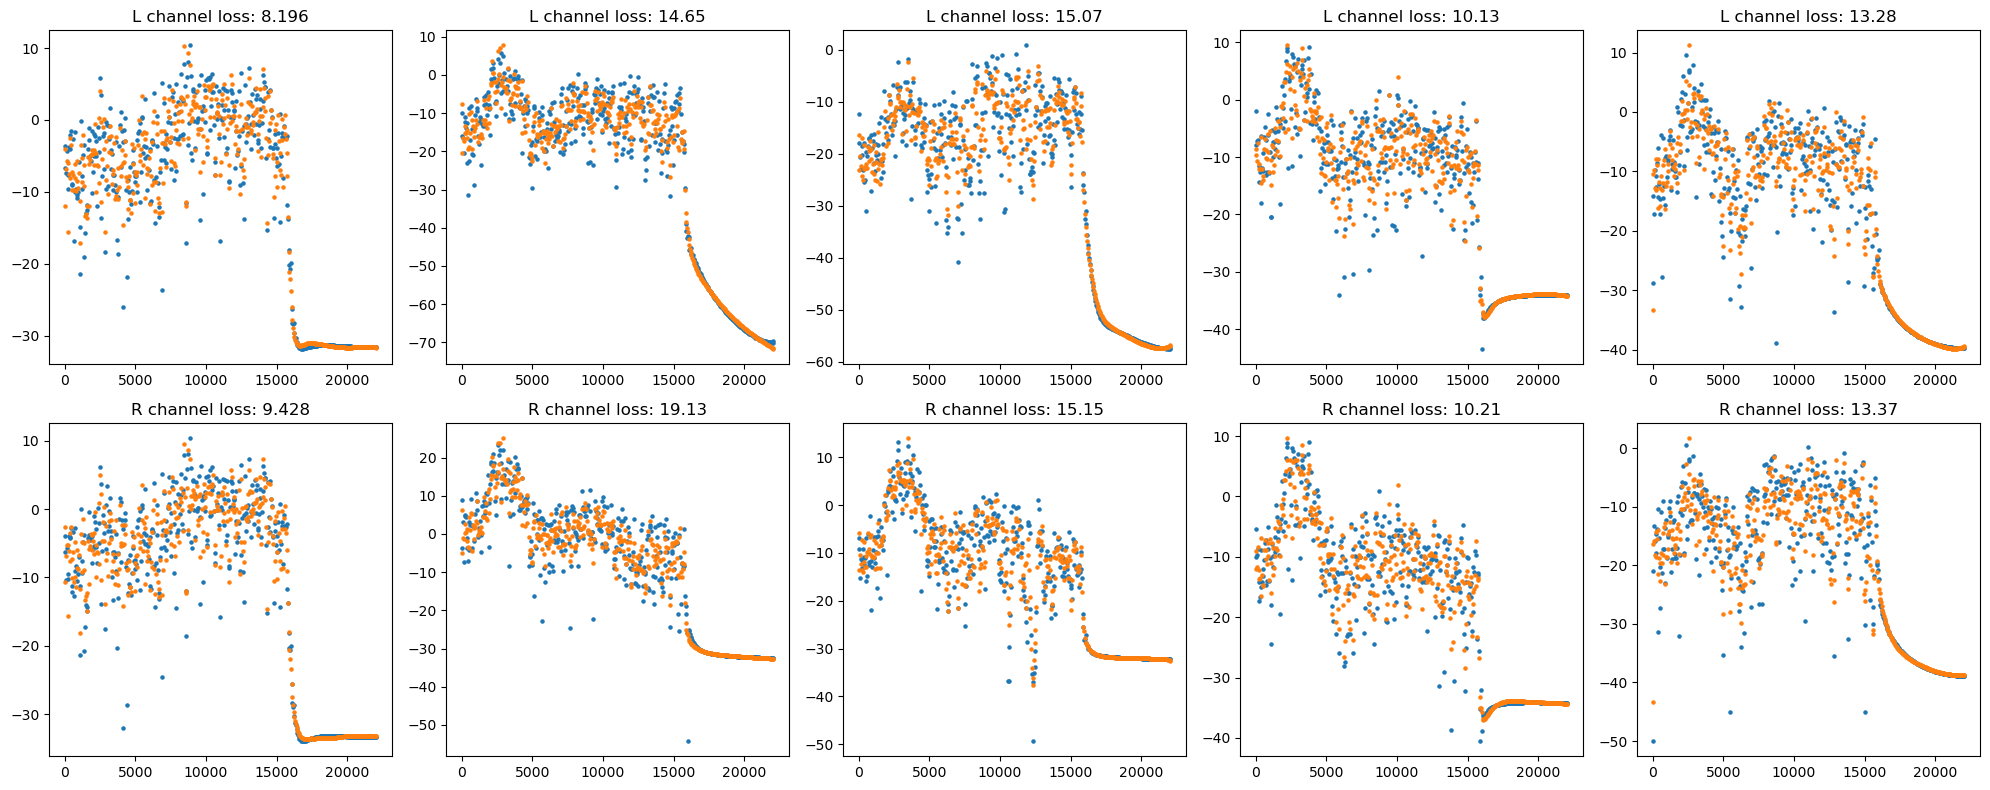

In [7]:
n = 5
plt.subplots(2,n, figsize=(20,8))
sp.reset_pointers()
auditory_enc.eval()
auditory_dec.eval()
with torch.no_grad():
    for i in range(n):

        _ , audio, _ = sp.get_batches(batch_size=batch_size, ttv='te')
        audio = torch.as_tensor(audio, dtype=torch.float32).view(-1, audio.shape[-1]).to(device)
        audio_recon = auditory_dec(auditory_enc(audio))
        loss = auditory_loss_fn(audio_recon, audio)
        x = np.random.randint(batch_size)
        audio, audio_recon = audio.cpu().numpy(), audio_recon.cpu().numpy()

        plt.subplot(2,n,i+1)
        plt.scatter(sp.freqs, audio[x,:freq_dim//2], s=5)
        plt.scatter(sp.freqs, audio_recon[x,:freq_dim//2], s=5)
        plt.title(f'L channel loss: {str(auditory_loss_fn(torch.as_tensor(audio_recon[x, :freq_dim//2]), torch.as_tensor(audio[x, :freq_dim//2])).numpy())[:5]}')
        plt.subplot(2,n,i+6)
        plt.scatter(sp.freqs, audio[x,freq_dim//2:], s=5)
        plt.scatter(sp.freqs, audio_recon[x,freq_dim//2:], s=5)
        plt.title(f'R channel loss: {str(auditory_loss_fn(torch.as_tensor(audio_recon[x, freq_dim//2:]), torch.as_tensor(audio[x, freq_dim//2:])).numpy())[:5]}')
plt.tight_layout()
plt.savefig(f'./report_figs/auditory_reconstructions.png', dpi=200,)

### train recurrent integrator

Notes from lab meeting 03/06/24:
- Do not provide head direction
- implement constraint on rnn from whittington paper

In [59]:
train_integration_module = True # False if load a pretrained model, else train from scratch

integration_module = RecIntegrationModule(auditory_enc=auditory_enc,
                                          auditory_dec=auditory_dec,
                                          vision_enc=vision_enc,
                                          vision_dec=vision_dec,
                                          n_rec_layers=n_rec_layers,
                                          rnn_hidden_dim=int_module_hidden_dim,
                                          integrator_type='rnn',
                                          aux_dim=aux_dim,
                                          use_proj=True,
                                          dropout=0.1,
                                          verbose=True,
                                          device=device).to(device)


integration_module.freeze_auditory_modules()
integration_module.freeze_vision_modules()

integration_module_timestamp = '20240606_185420'
integration_module.load_state_dict(torch.load(f'./trained_models/{recording_name}_integration_module_{int_module_hidden_dim}_{n_rec_layers}_{integration_module_timestamp}.pth'))
logger.info(f'Successfully loaded integration module at timestamp: {integration_module_timestamp}')

def save_integration_module(timestamp):
    # implement new saving scheme: save after each epoch at minimum loss
    if timestamp is None:
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    torch.save(integration_module.state_dict(), f'./trained_models/{recording_name}_integration_module_{int_module_hidden_dim}_{n_rec_layers}_{timestamp}.pth')
    logger.info(f'Saved integration module at timestamp: {timestamp}')

2024-06-13 15:15:22.530 | DEBUG    | brain_modules:__init__:248 - Using projection layers for auditory and visual modules.
2024-06-13 15:15:22.533 | INFO     | brain_modules:freeze_auditory_modules:281 - Gradient for auditory modules DISABLED.
2024-06-13 15:15:22.533 | INFO     | brain_modules:freeze_vision_modules:265 - Gradient for vision modules DISABLED.
2024-06-13 15:15:22.577 | INFO     | __main__:<module>:22 - Successfully loaded integration module at timestamp: 20240606_185420


In [86]:
if not train_integration_module:
    integration_module_timestamp = '20240606_185420'
    integration_module.load_state_dict(torch.load(f'./trained_models/{recording_name}_integration_module_{int_module_hidden_dim}_{n_rec_layers}_{integration_module_timestamp}.pth'))
    logger.info(f'Successfully loaded integration module at timestamp: {integration_module_timestamp}')
    
else:
    runtime_start_timestamp = timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    run = wandb.init(project="sensory-integration")
    
    # train integration module
    n_epochs = 15
    n_cycles = 100

    min_vision_recon_loss = np.inf
    min_auditory_recon_loss = np.inf

    audio_loss_if_pred_9th = []
    img_loss_if_pred_9th = []

    for cycle in range(n_cycles):
        optim = torch.optim.Adam(integration_module.parameters(), lr=8*1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',
                                                                factor=0.5,
                                                                patience=25,
                                                                threshold=0.01)
        for epoch in range(n_epochs):
            sp.reset_pointers()
            epoch_train_loss = []
            epoch_test_loss = []

            

            # train the integration module
            for iter in range(len(sp.train_idxs)// batch_size):
                integration_module.train()
                img, audios, auxs = sp.get_batches(batch_size=batch_size, ttv='train')

                # do not provide hd
                auxs = auxs[:,:,[0,1,2]]

                next_img, next_audio = integration_module(img[:,0:-1:rec_interval,...], audios[:,0:-1:rec_interval,...], auxs[:,0:-1:rec_interval,...]) # if rec_interval = 3, then step 0, 3, 6 is provided to predict 9th step

                audio_loss = auditory_loss_fn(next_audio, torch.as_tensor(audios[:,-1, ...], dtype=torch.float32, device=device))
                img_loss = visual_loss_fn(next_img, torch.as_tensor(img[:,-1,...], dtype=torch.float32, device=device))
                
                if epoch == 0 and cycle == 0 and iter==0:
                    logger.debug(f'Initialised training with auditory loss {audio_loss.item()} and visial loss {img_loss.item()}\n')

                loss = audio_loss + img_loss + alpha*torch.norm(integration_module.rnn.weight_hh_l0, p=2) # L2 regularization
                optim.zero_grad()
                loss.backward()

                optim.step()
                scheduler.step(loss)
                epoch_train_loss.append([audio_loss.detach().cpu().numpy(), img_loss.detach().cpu().numpy()])

                # what if we predict the 10th step audio by the 9th?
                wandb.log({'audio_loss': audio_loss.item(), 'img_loss': img_loss.item()})
                if epoch == 0 and cycle == 0:
                    audio_loss_if_pred_9th.append(torch.nn.MSELoss(reduction='none')(torch.as_tensor(audios[:,-2,...], dtype=torch.float32, device=device),
                                                        torch.as_tensor(audios[:,-1, ...], dtype=torch.float32, device=device)).detach().cpu().numpy())
                    img_loss_if_pred_9th.append(torch.nn.BCELoss(reduction='none')(torch.as_tensor(img[:,-2,...], dtype=torch.float32, device=device),
                                                        torch.as_tensor(img[:,-1,...], dtype=torch.float32, device=device)).detach().cpu().numpy())

            # test the integration module
            for iter in range(len(sp.test_idxs)// batch_size):
                integration_module.eval()

                with torch.no_grad():
                    img, audios, auxs = sp.get_batches(batch_size=batch_size, ttv='test')

                    # do not provide hd
                    auxs = auxs[:,:,[0,1,2]]

                    next_img, next_audio = integration_module(img[:,0:-1:rec_interval,...], audios[:,0:-1:rec_interval,...], auxs[:,0:-1:rec_interval,...])

                    audio_loss = auditory_loss_fn(next_audio, torch.as_tensor(audios[:,-1, ...], dtype=torch.float32, device=device))
                    img_loss = visual_loss_fn(next_img, torch.as_tensor(img[:,-1,...], dtype=torch.float32, device=device))

                    epoch_test_loss.append([audio_loss.detach().cpu().numpy(), img_loss.detach().cpu().numpy()])

                wandb.log({'test image batch': wandb.Image(np.swapaxes(next_img[0].cpu().numpy(),0,2))})

            if epoch == 0 and cycle == 0:
                logger.debug(f'loss if predict by last seen step: audio {np.mean(audio_loss_if_pred_9th)} and img {np.mean(img_loss_if_pred_9th)}\n')
            
            
            break
            logger.info(f'epoch {epoch+1} completed with auditory train loss {str(np.vstack(epoch_train_loss).mean(0)[0])[:5]} test loss {str(np.vstack(epoch_test_loss).mean(0)[0])[:5]} and visual train loss {str(np.vstack(epoch_train_loss).mean(0)[1])[:5]} test loss {str(np.vstack(epoch_test_loss).mean(0)[1])[:5]}')
        break
        if img_loss.detach().cpu().numpy() < min_vision_recon_loss or audio_loss.detach().cpu().numpy() < min_auditory_recon_loss:
                min_vision_recon_loss = np.min([min_vision_recon_loss, img_loss.detach().cpu().numpy()])
                min_auditory_recon_loss = np.min([min_auditory_recon_loss, audio_loss.detach().cpu().numpy()])
                save_integration_module(timestamp=runtime_start_timestamp)

        if os.path.exists('./stop_integration_training.txt'):
            save_integration_module(timestamp=runtime_start_timestamp)
            break
        
    # save_integration_module(timestamp=runtime_start_timestamp)

2024-06-13 15:34:23.671 | DEBUG    | __main__:<module>:47 - Initialised training with auditory loss 33.5439338684082 and visial loss 0.5743428468704224



KeyboardInterrupt: 

In [91]:
audio_loss_if_pred_9th[0].mean(1)

array([ 87.35736 ,  72.4775  ,  95.05833 ,  63.60257 , 108.10916 ,
        59.750603,  90.823395,  93.65763 ,  71.37619 ,  92.015816,
        76.40237 ,  68.8831  ,  55.21066 ,  51.906017,  62.60788 ,
        53.730476,  92.88095 , 103.81505 ,  56.05042 ,  69.617065,
        71.38863 , 142.94318 ,  96.6543  ,  54.828716,  58.975986,
        79.022644,  58.351925, 101.87131 ,  60.7717  ,  70.384315,
        79.139854,  80.06082 ,  71.19133 ,  82.69606 ,  72.138885,
        66.652626,  84.21122 , 177.96324 , 123.6377  , 123.930916,
        48.78111 ,  67.20169 ,  74.617805,  42.413002,  56.095753,
        76.74511 ,  84.12696 ,  50.249393,  82.87176 ,  70.653854,
        59.570618,  66.36645 ,  57.37444 ,  50.034958,  82.07187 ,
        76.57043 , 116.87655 ,  57.205032,  90.62778 , 177.01361 ,
       115.41184 ,  61.612602,  56.31856 , 181.38046 ,  60.914963,
        49.643944,  66.48999 ,  54.418377,  89.85876 ,  57.524612,
        93.368744, 102.237274,  56.63521 ,  63.803802,  67.914

In [94]:
img_loss_if_pred_9th[0].mean((1,2,3))

array([0.56986743, 0.5808347 , 0.5289552 , 0.54566014, 0.5325469 ,
       0.54728913, 0.4905817 , 0.5702874 , 0.5756657 , 0.5323323 ,
       0.5976689 , 0.5872155 , 0.60102886, 0.61239916, 0.6303533 ,
       0.5437156 , 0.602289  , 0.5847947 , 0.5709467 , 0.4786385 ,
       0.53422993, 0.5213595 , 0.5112864 , 1.0287858 , 0.5461701 ,
       0.5823432 , 0.51764816, 0.56432444, 0.5634201 , 0.49226803,
       0.8840673 , 0.6232882 , 0.573402  , 0.5952413 , 0.5616622 ,
       0.58938044, 0.9343713 , 0.46398678, 0.4994503 , 0.51029724,
       0.53980005, 0.59758645, 0.5501742 , 0.5502438 , 0.60688156,
       0.4622609 , 0.46401232, 0.672323  , 0.5268355 , 0.56220585,
       0.6125503 , 0.60475194, 1.1639466 , 0.55942315, 0.51833063,
       0.5725713 , 0.6617704 , 0.5242935 , 0.5260791 , 0.5340314 ,
       0.53487635, 1.4637799 , 0.53495437, 0.7394083 , 0.5966477 ,
       0.5970672 , 0.54633725, 0.5367125 , 0.5525102 , 0.64210546,
       0.5188497 , 0.5568251 , 0.6233642 , 0.49460402, 0.57762

In [96]:
# test the integration module
actual_audio_loss = []
actual_img_loss = []
for iter in range(len(sp.test_idxs)// batch_size):
    integration_module.eval()

    with torch.no_grad():
        img, audios, auxs, pos = sp.get_batches(batch_size=batch_size, ttv='test', get_pos=True)

        # do not provide hd
        auxs = auxs[:,:,[0,1,2]]
        
        next_img, next_audio = integration_module(img[:,0:-1:rec_interval,...], audios[:,0:-1:rec_interval,...], auxs[:,0:-1:rec_interval,...])

        audio_loss = torch.nn.MSELoss(reduction='none')(next_audio, torch.as_tensor(audios[:,-1, ...], dtype=torch.float32, device=device))
        img_loss = torch.nn.BCELoss(reduction='none')(next_img, torch.as_tensor(img[:,-1,...], dtype=torch.float32, device=device))

        actual_audio_loss.append(audio_loss.detach().cpu().numpy())
        actual_img_loss.append(img_loss.detach().cpu().numpy())

In [98]:
actual_audio_loss[0].shape

(600, 884)

In [103]:
import numpy as np
from scipy import stats

t_stat, p_value = stats.ttest_ind(img_loss_if_pred_9th[0].mean((1,2,3)), actual_img_loss[0].mean((1,2,3)))

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Determine if the p-value is less than the significance level (0.05)
alpha = 0.05
if p_value < alpha:
    print("The means of the two groups are significantly different.")
else:
    print("The means of the two groups are not significantly different.")

T-statistic: 3.1156652328674643
P-value: 0.0018789150860561738
The means of the two groups are significantly different.


In [14]:
print(f'loss if predict by last seen step: audio {np.mean(audio_loss_if_pred_9th)} and img {np.mean(img_loss_if_pred_9th)}\n')
print(f'test set audio loss {audio_loss.item()} and img loss {img_loss.item()}')

loss if predict by last seen step: audio nan and img nan

test set audio loss 48.17866516113281 and img loss 0.5715214014053345


In [65]:
batch_size

600

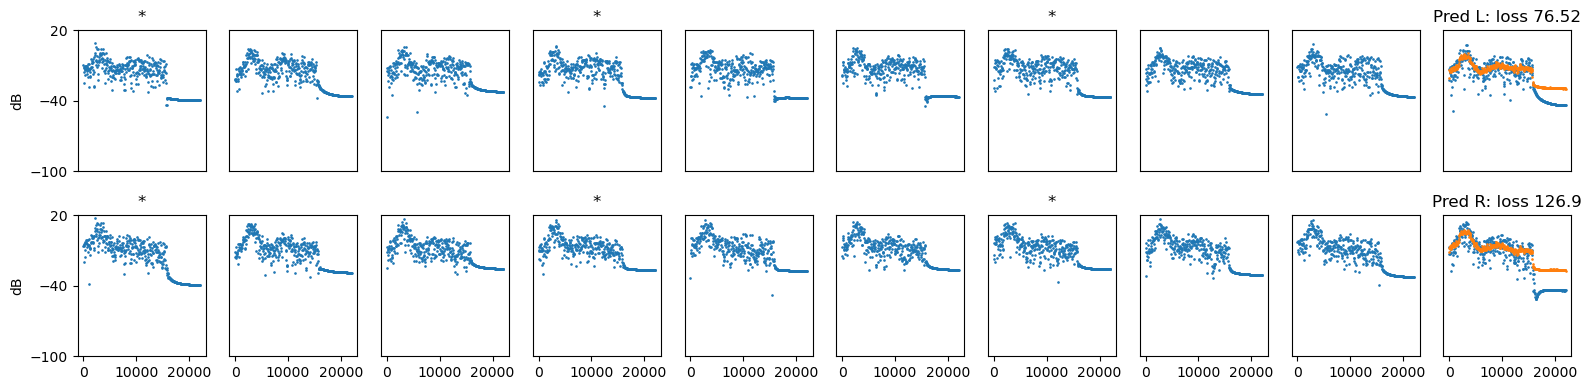

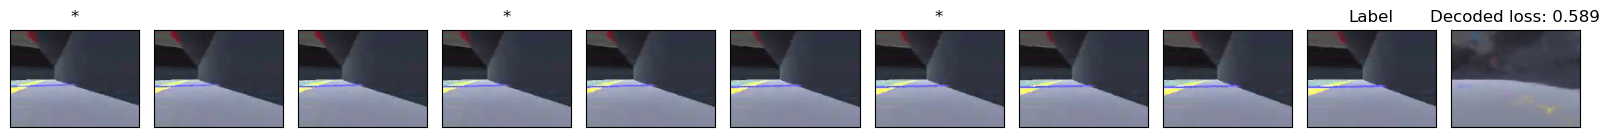

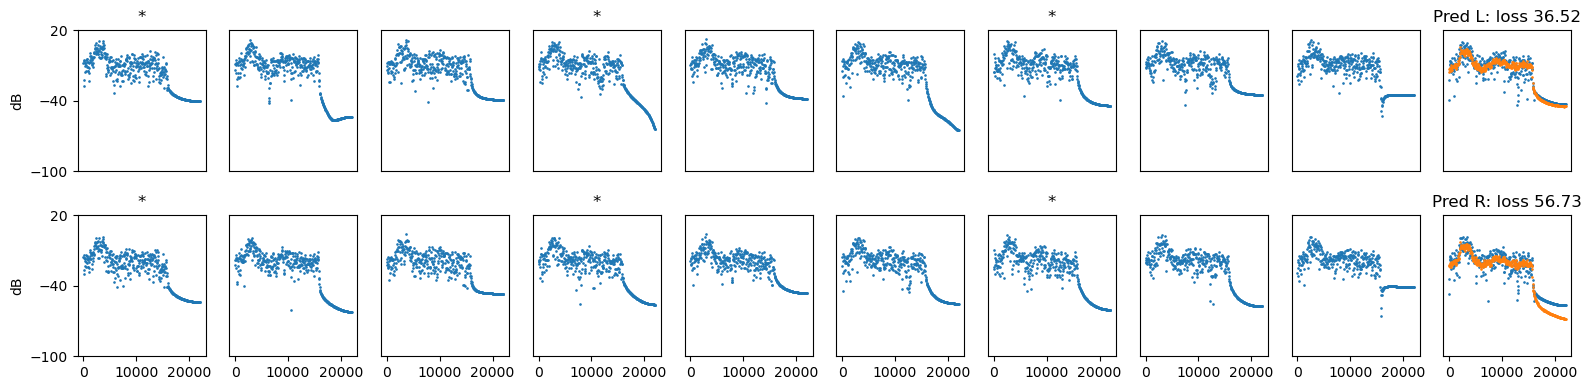

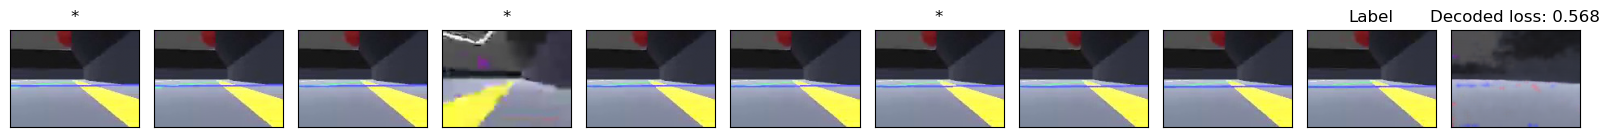

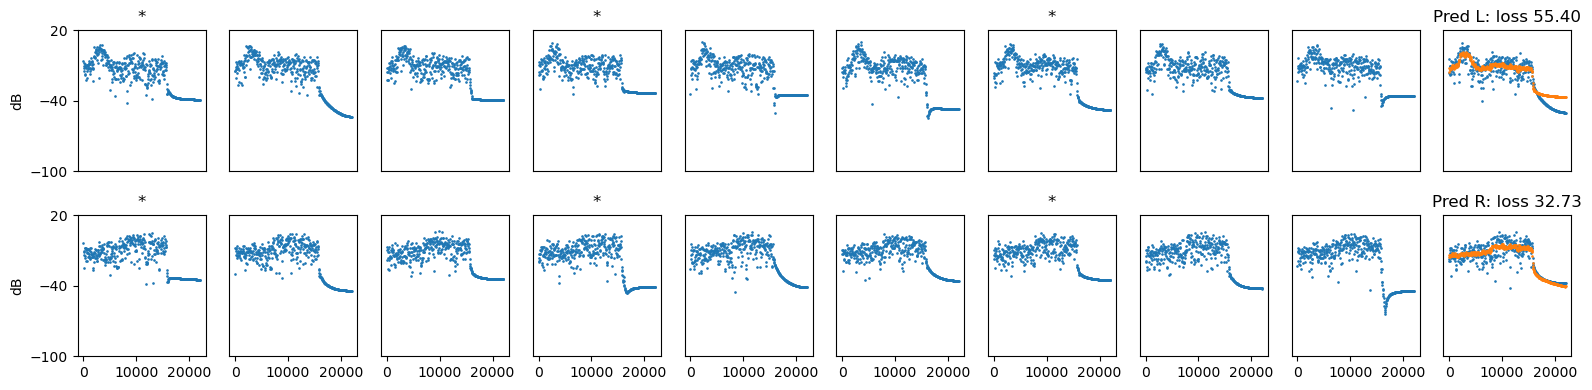

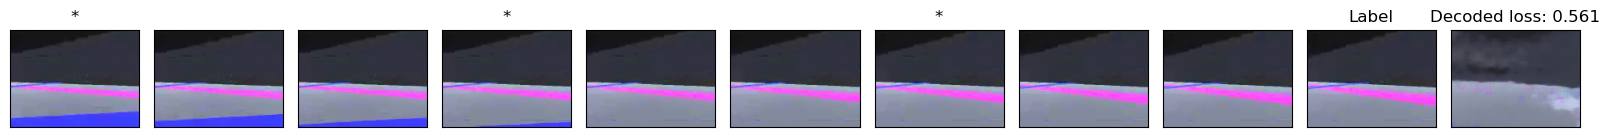

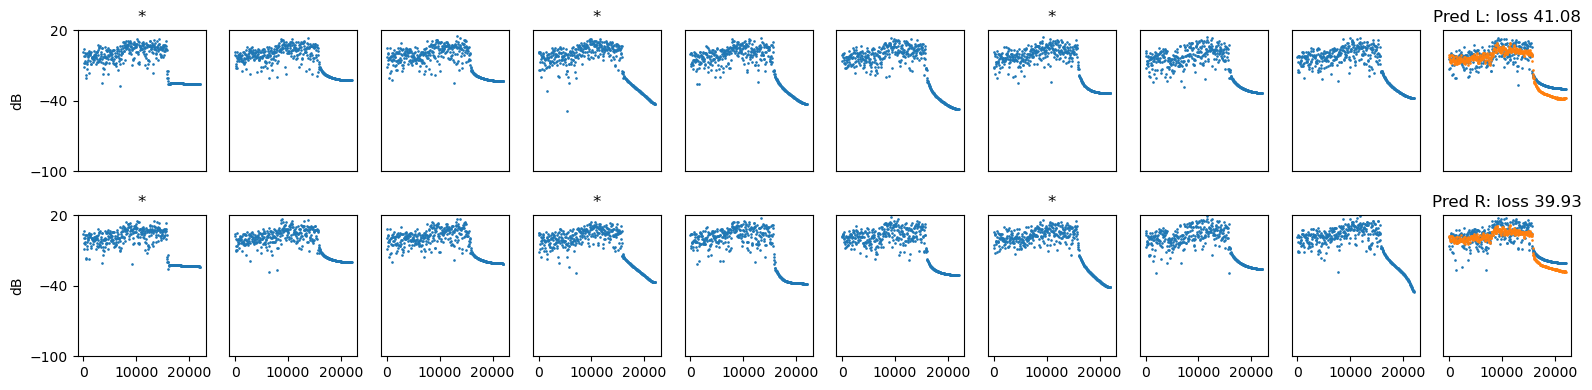

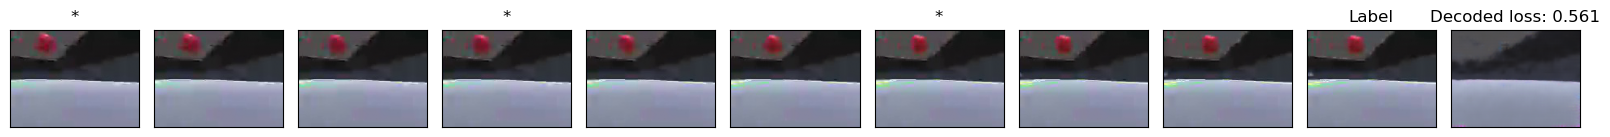

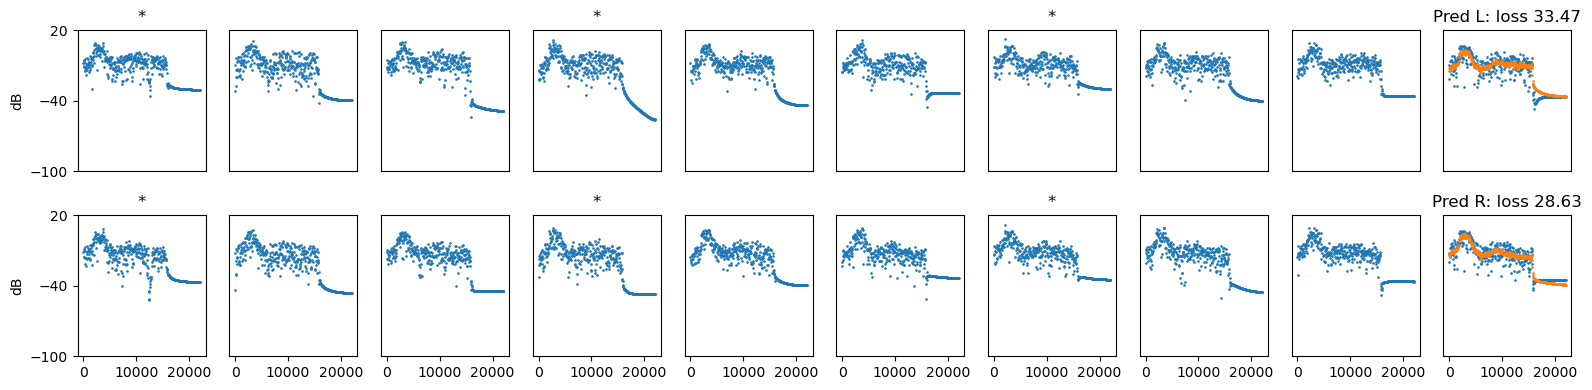

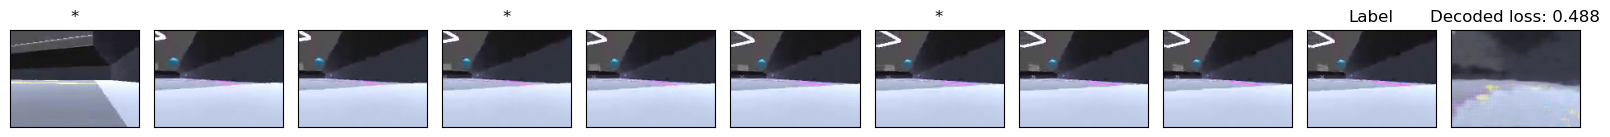

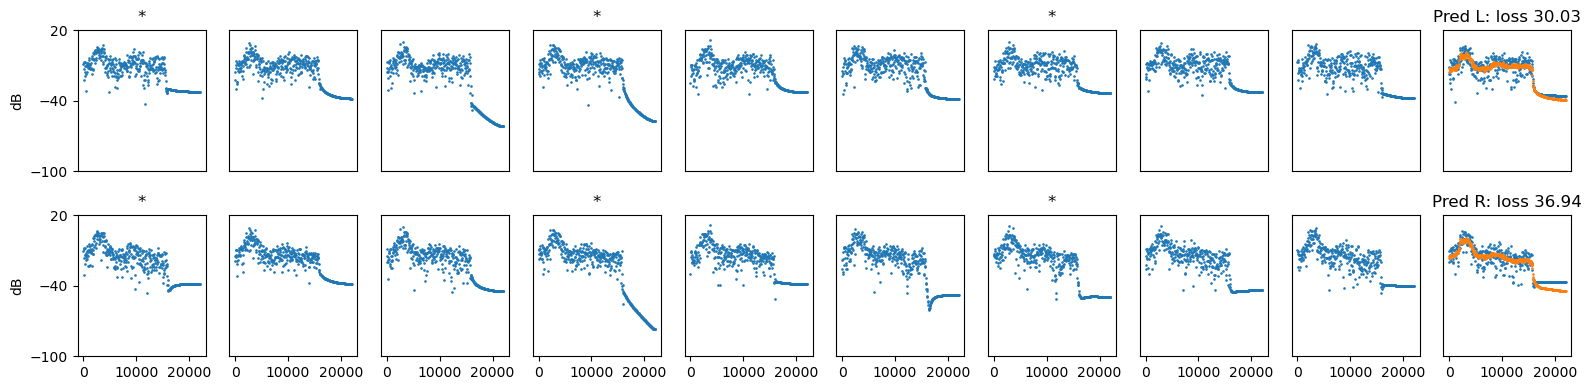

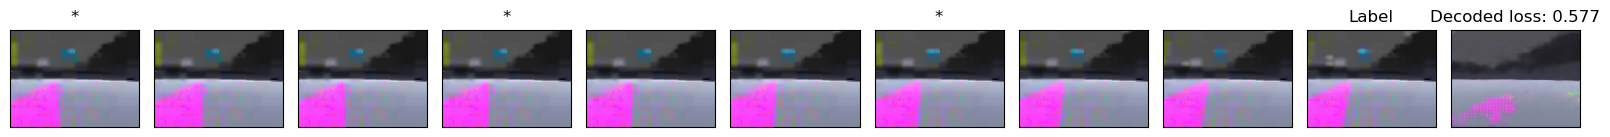

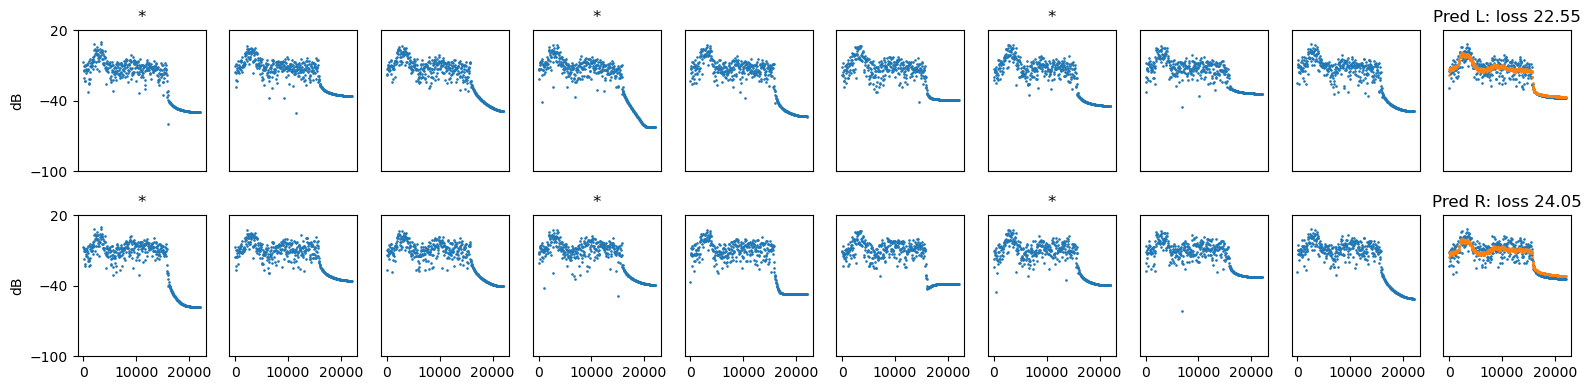

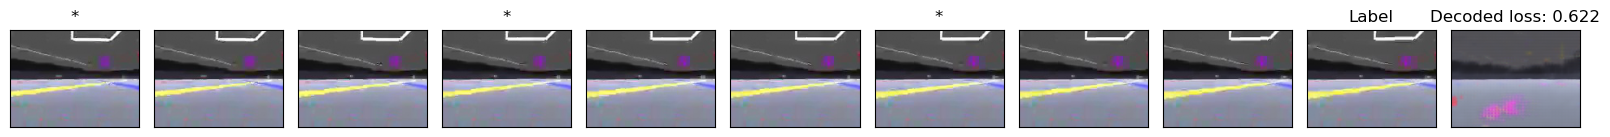

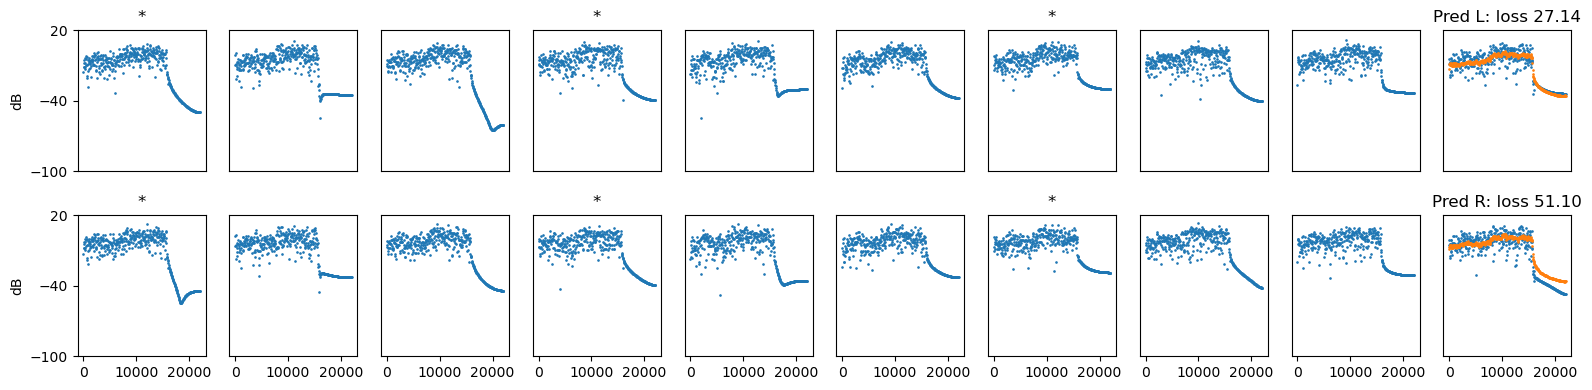

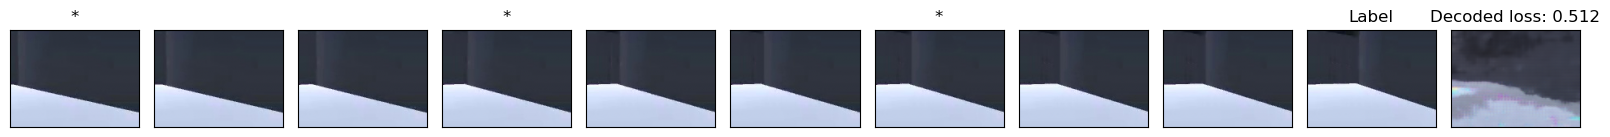

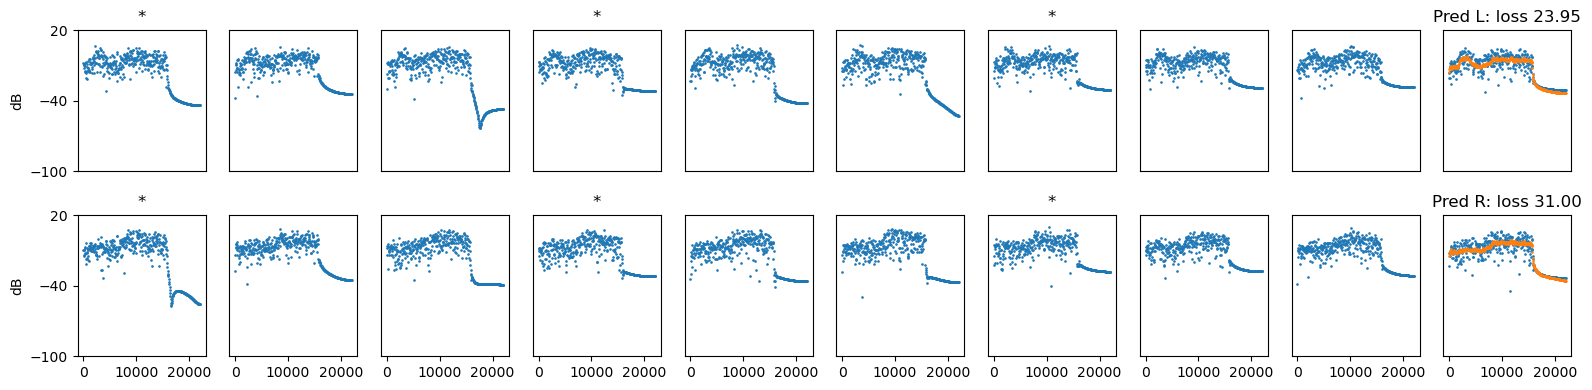

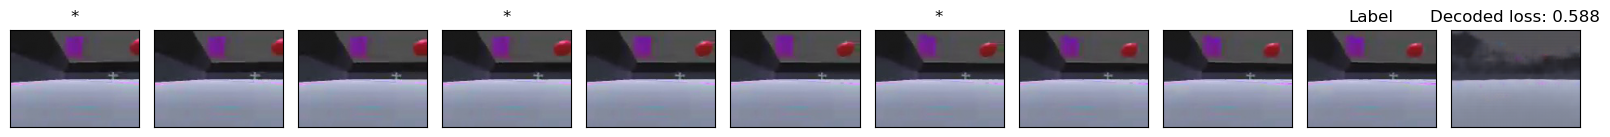

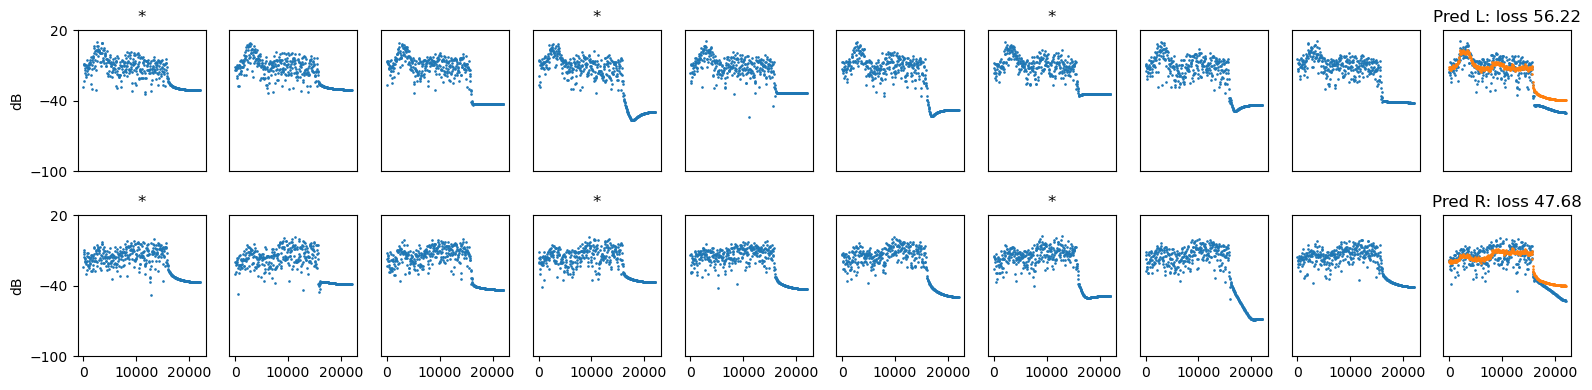

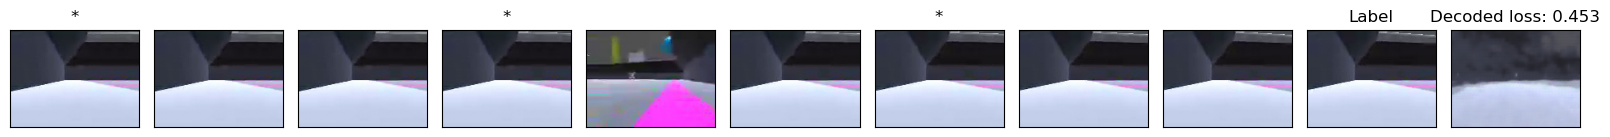

In [107]:
for _ in range(10):
    i = np.random.randint(batch_size)
    # audio
    plt.subplots(2,10, figsize=(16,4))
    for j in range(9):
        plt.subplot(2,10,j+1)
        plt.scatter(sp.freqs,audios[i,j,:freq_dim//2], s=0.8)
        plt.xticks([])
        plt.ylim([-100,20])
        plt.yticks([]) if j > 0 else plt.yticks([-100,-40, 20])
        plt.ylabel('dB') if j == 0 else None
        if j % rec_interval == 0: plt.title(f'*')
        plt.subplot(2,10,j+11)
        plt.scatter(sp.freqs,audios[i,j,freq_dim//2:], s=0.8)
        plt.ylim([-100,20])
        plt.yticks([])
        plt.yticks([]) if j > 0 else plt.yticks([-100, -40, 20])
        plt.ylabel('dB') if j == 0 else None
        if j % rec_interval == 0: plt.title(f'*')

    plt.subplot(2,10,10)
    plt.scatter(sp.freqs, audios[i,9,:freq_dim//2], s=0.8)
    plt.scatter(sp.freqs, next_audio[i,:freq_dim//2].cpu().numpy(), s=0.8)
    plt.ylim([-100,20])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Pred L: loss {str(auditory_loss_fn(torch.as_tensor(next_audio[i,:freq_dim//2], dtype=torch.float32, device=device), torch.as_tensor(audios[i,9,:freq_dim//2], dtype=torch.float32, device=device)).item())[:5]}')

    plt.subplot(2,10,20)
    plt.scatter(sp.freqs, audios[i,9,freq_dim//2:], s=0.8)
    plt.scatter(sp.freqs, next_audio[i,freq_dim//2:].cpu().numpy(), s=0.8)
    plt.ylim([-100,20])
    plt.yticks([])
    plt.title(f'Pred R: loss {str(auditory_loss_fn(torch.as_tensor(next_audio[i,freq_dim//2:], dtype=torch.float32, device=device), torch.as_tensor(audios[i,9,freq_dim//2:], dtype=torch.float32, device=device)).item())[:5]}')
    plt.savefig(f'./report_figs/next_step_audio_reconstructions.png', dpi=200)
    plt.tight_layout()
    plt.show()

    # img
    plt.subplots(1,11, figsize=(16,2))
    for j in range(9):
        plt.subplot(1,11,j+1)
        plt.imshow(np.swapaxes(img[i,j],0,2))
        plt.xticks([])
        plt.yticks([])
        if j % rec_interval == 0: plt.title(f'*')


    plt.subplot(1,11,10)
    plt.imshow(np.swapaxes(img[i,-1],0,2))
    plt.xticks([])
    plt.yticks([])
    plt.title('Label')

    plt.subplot(1,11,11)
    plt.imshow(np.swapaxes(next_img[i].cpu().numpy(),0,2))
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Decoded loss: {str(visual_loss_fn(next_img[i], torch.as_tensor(img[i,-1], dtype=torch.float32, device=device)).item())[:5]}')
    plt.savefig(f'./report_figs/next_step_visual_reconstructions.png', dpi=200)
    plt.tight_layout()

    plt.show()



### train unimodel integrator - video

In [6]:
from brain_modules import UniModalRecModule
int_module_hidden_dim = 400
n_rec_layers = 1
aux_dim = 3
alpha = 1e-5
rec_interval = 3 # frame rate provided to the rec network. 1 = 0.02 seconds

unimodal_integration_module = UniModalRecModule(enc=vision_enc,
                                    dec=vision_dec,
                                    modality='visual',
                                    rnn_hidden_dim=int_module_hidden_dim,
                                    n_rec_layers=n_rec_layers,
                                    integrator_type='rnn',
                                    aux_dim=aux_dim,
                                    use_proj=True,
                                    dropout=0.1,
                                    device=device).to(device)
unimodal_integration_module.freeze_sensory_modules()

train_integration_module = True # False if load a pretrained model, else train from scratch

2024-06-11 17:48:02.620 | DEBUG    | brain_modules:__init__:402 - Using projection layers for auditory and visual modules.
2024-06-11 17:48:02.624 | INFO     | brain_modules:freeze_sensory_modules:417 - Gradient for visual modules DISABLED.


In [7]:
if not train_integration_module:
    integration_module_timestamp = '20240528_184735'
    unimodal_integration_module.load_state_dict(torch.load(f'./trained_models/{recording_name}_integration_module{int_module_hidden_dim}_{n_rec_layers}_{integration_module_timestamp}.pth'))
    logger.info(f'Successfully loaded integration module at timestamp: {integration_module_timestamp}')
    
else:
    run = wandb.init(project="sensory-integration-unimodal")
    
    # train integration module
    n_epochs = 15
    n_cycles = 100

    for cycle in range(n_cycles):
        optim = torch.optim.Adam(unimodal_integration_module.parameters(), lr=8*1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',
                                                                factor=0.5,
                                                                patience=25,
                                                                threshold=0.01)
        for epoch in range(n_epochs):
            sp.reset_pointers()
            epoch_train_loss = []
            epoch_test_loss = []

            img_loss_if_pred_9th = []

            # train the integration module
            for iter in range(len(sp.train_idxs)// batch_size):
                unimodal_integration_module.train()
                img, audios, auxs = sp.get_batches(batch_size=batch_size, ttv='train')
                
                # do not provide hd
                auxs = auxs[:,:,[0,1,2]]

                next_img = unimodal_integration_module(img[:,0:-1:rec_interval,...], auxs[:,0:-1:rec_interval,...])

                img_loss = visual_loss_fn(next_img, torch.as_tensor(img[:,-1,...], dtype=torch.float32, device=device))
                
                if epoch == 0 and cycle == 0 and iter==0:
                    logger.debug(f'Initialised training with visial loss {img_loss.item()}\n')

                optim.zero_grad()
                img_loss.backward()

                optim.step()
                scheduler.step(img_loss)
                epoch_train_loss.append([0, img_loss.detach().cpu().numpy()])

                # what if we predict the 10th step audio by the 9th?
                wandb.log({'img_loss': img_loss.item()})
                if epoch == 0 and cycle == 0:
                    
                    img_loss_if_pred_9th.append(visual_loss_fn(torch.as_tensor(img[:,-2,...], dtype=torch.float32, device=device),
                                                        torch.as_tensor(img[:,-1,...], dtype=torch.float32, device=device)).detach().cpu().numpy())

            # test the integration module
            for iter in range(len(sp.test_idxs)// batch_size):
                unimodal_integration_module.eval()

                with torch.no_grad():
                    img, audios, auxs = sp.get_batches(batch_size=batch_size, ttv='test')

                    # do not provide hd
                    auxs = auxs[:,:,[0,1,2]]
                    
                    next_img = unimodal_integration_module(img[:,0:-1:rec_interval,...], auxs[:,0:-1:rec_interval,...])

                    img_loss = visual_loss_fn(next_img, torch.as_tensor(img[:,-1,...], dtype=torch.float32, device=device))

                    epoch_test_loss.append([0, img_loss.detach().cpu().numpy()])

            wandb.log({'test image batch': wandb.Image(np.swapaxes(next_img[0].cpu().numpy(),0,2))})
            if epoch == 0 and cycle == 0:
                logger.debug(f'loss if predict by last seen step: img {np.mean(img_loss_if_pred_9th)}\n')
            
            logger.info(f'epoch {epoch+1} completed with auditory train loss {str(np.vstack(epoch_train_loss).mean(0)[0])[:5]} test loss {str(np.vstack(epoch_test_loss).mean(0)[0])[:5]} and visual train loss {str(np.vstack(epoch_train_loss).mean(0)[1])[:5]} test loss {str(np.vstack(epoch_test_loss).mean(0)[1])[:5]}')

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    torch.save(unimodal_integration_module.state_dict(), f'./trained_models/{recording_name}_unimodal_integration_module_{int_module_hidden_dim}_{n_rec_layers}_{timestamp}.pth')
    logger.info(f'Saved unimodal integration module at timestamp: {timestamp}')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cngzlsh. Use `wandb login --relogin` to force relogin


2024-06-11 17:48:11.711 | DEBUG    | __main__:<module>:39 - Initialised training with visial loss 0.7217974662780762

2024-06-11 17:49:48.703 | DEBUG    | __main__:<module>:73 - loss if predict by last seen step: img 0.6265230774879456

2024-06-11 17:49:48.704 | INFO     | __main__:<module>:75 - epoch 1 completed with auditory train loss 0.0 test loss 0.0 and visual train loss 0.604 test loss 0.586
2024-06-11 17:51:12.803 | INFO     | __main__:<module>:75 - epoch 2 completed with auditory train loss 0.0 test loss 0.0 and visual train loss 0.581 test loss 0.574
2024-06-11 17:52:35.414 | INFO     | __main__:<module>:75 - epoch 3 completed with auditory train loss 0.0 test loss 0.0 and visual train loss 0.573 test loss 0.569
2024-06-11 17:53:58.894 | INFO     | __main__:<module>:75 - epoch 4 completed with auditory train loss 0.0 test loss 0.0 and visual train loss 0.567 test loss 0.563
2024-06-11 17:55:25.297 | INFO     | __main__:<module>:75 - epoch 5 completed with auditory train loss 

KeyboardInterrupt: 